# 02. Modeling medical appointments no-show
### Andrea Rabinelli
#### Capstone project - Udacity Machine Learning Engineer Nanodegree

In this notebook we will:
* Load the dataset cleaned and with the additional features that was built in the previous notebook
* Do some final data preparation in order to make it suitable for training, validating, and testing the model (including dealing with class imbalance)
* Define the metrics that we are going to consider, and what they mean in this specific context
* Define a baseline model and compute its metrics
* Define a deep and wide neural network and a XGBoost model, picking the best configurations resulted from hyperparameter tuning
* Discuss the learnings, limitations, and future research inspiration

In [1]:
#import dependencies
import datetime, json, os
import mlflow
import eli5

import seaborn as sns
import pandas as pd
import numpy as np 
import tensorflow as tf 
import xgboost as xgb
import sklearn.metrics

from sklearn.model_selection import train_test_split
from eli5.permutation_importance import get_score_importances

import warnings
warnings.filterwarnings('ignore')

mlflow.set_experiment("Medical appointment no-show")
sns.set_context("talk")
sns.set_palette(sns.diverging_palette(220, 20, n=2))

/Users/arabinelli/.pyenv/versions/3.7.7/lib/python3.7/site-packages/eli5/base_utils.py:28: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  init_args = inspect.getargspec(class_.__init__)
/Users/arabinelli/.pyenv/versions/3.7.7/lib/python3.7/site-packages/eli5/base_utils.py:28: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  init_args = inspect.getargspec(class_.__init__)
/Users/arabinelli/.pyenv/versions/3.7.7/lib/python3.7/site-packages/eli5/base_utils.py:36: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  return attr.s(class_, these=these, init=False, slots=True, **attrs_kwargs)  # type: ignore
/Users/arabinelli/.pyenv/versions/3.7.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer modul

In [2]:
# set some jupyter magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
CSV_PATH = "data/no_show_feature_engineered_no_extreme_locations_no_SMS_issues.csv"
no_show_df = pd.read_csv(CSV_PATH)
no_show_df.head()

,patientId,appointmentId,gender,scheduledDay,appointmentDay,age,neighborhood,scholarship,hypertension,diabetes,...,appointmentDayDOW__Monday,appointmentDayDOW__Saturday,appointmentDayDOW__Thursday,appointmentDayDOW__Tuesday,appointmentDayDOW__Wednesday,lat,lon,distanceFromCenter,distanceFromCenterLat,distanceFromCenterLon
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29 00:00:00,62,JARDIM DA PENHA,False,True,False,...,0,0,0,0,0,0.490525,-0.169426,-0.198132,-0.280227,-0.201355
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29 00:00:00,56,JARDIM DA PENHA,False,False,False,...,0,0,0,0,0,0.490525,-0.169426,-0.198132,-0.280227,-0.201355
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29 00:00:00,62,MATA DA PRAIA,False,False,False,...,0,0,0,0,0,0.788316,-0.166879,-0.190882,0.089317,-0.199223
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29 00:00:00,8,PONTAL DE CAMBURI,False,False,False,...,0,0,0,0,0,0.341636,-0.170699,-0.201469,-0.464992,-0.200074
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29 00:00:00,56,JARDIM DA PENHA,False,True,True,...,0,0,0,0,0,0.490525,-0.169426,-0.198132,-0.280227,-0.201355


Here we do some data pre-processing to turn the dataset into something that can be easily used by the model (e.g. normalizing values, turing gender into a boolean variable, etc.)

We also select the features and the target variable.

In [4]:
# encode the gender as a binary
# NOTE: the gender didn't seem to affect no show by itself, but we're going to keep it and
#       and verify if the model can still use it in conjunction with other variables
no_show_df["isFemale"] = no_show_df["gender"] == "F"

# select the columns that we want to keep
FEATURE_COLS = ["age","scholarship","hypertension","diabetes","alcoholism","handicap","smsSent",
                "daysInAdvance","lat","lon","isFemale","distanceFromCenter","scheduledDayHour",
                "otherAppointmentsOnSameDay","previouslyMissed"]
# add the features referring to the days of the week
days_of_weeks_cols = [col_name for col_name in no_show_df.columns if "appointmentDayDOW__" in col_name]
FEATURE_COLS += days_of_weeks_cols

# target column
TARGET_COLUMN = "noShow"

# prepare dataset for models
no_show_df["age"] = (no_show_df["age"]-no_show_df["age"].mean())/no_show_df["age"].std()

no_show_df["daysInAdvance"] = (no_show_df["daysInAdvance"]-no_show_df["daysInAdvance"].min())/\
                                (no_show_df["daysInAdvance"].max() - no_show_df["daysInAdvance"].min())

no_show_df["scheduledDayHour"] = (no_show_df["scheduledDayHour"]-no_show_df["scheduledDayHour"].min())/\
                                (no_show_df["scheduledDayHour"].max() - no_show_df["scheduledDayHour"].min())

no_show_df["previouslyMissed"] = (no_show_df["previouslyMissed"]-no_show_df["previouslyMissed"].min())/\
                                (no_show_df["previouslyMissed"].max() - no_show_df["previouslyMissed"].min())

no_show_df["noShow"] = (no_show_df["noShow"])*1

In [5]:
no_show_df[FEATURE_COLS].describe()

,age,daysInAdvance,lat,lon,distanceFromCenter,scheduledDayHour,otherAppointmentsOnSameDay,previouslyMissed,appointmentDayDOW__Friday,appointmentDayDOW__Monday,appointmentDayDOW__Saturday,appointmentDayDOW__Thursday,appointmentDayDOW__Tuesday,appointmentDayDOW__Wednesday
count,8.053300e+04,80533.000000,80533.000000,80533.000000,80533.000000,80533.000000,80533.000000,80533.000000,80533.000000,80533.000000,80533.000000,80533.00000,80533.000000,80533.000000
mean,1.051702e-16,0.057451,0.272254,-0.183060,-0.184022,0.317405,0.144587,0.019294,0.139024,0.168614,0.000484,0.16104,0.264016,0.266822
std,1.000000e+00,0.085479,0.602134,0.014814,0.010330,0.214521,0.351686,0.039277,0.345973,0.374413,0.022001,0.36757,0.440811,0.442301
min,-1.611033e+00,0.000000,-0.629942,-0.209515,-0.204630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,-8.319203e-01,0.000000,-0.263382,-0.193611,-0.192489,0.133333,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,-9.523425e-03,0.022346,0.212190,-0.183430,-0.184147,0.266667,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,8.128735e-01,0.083799,0.698255,-0.173670,-0.174420,0.466667,0.000000,0.055556,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,3.366632e+00,1.000000,1.290402,-0.149047,-0.164147,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [6]:
# get training, validation, and test after 
from imblearn.over_sampling import SMOTE, RandomOverSampler

SEQUENTIAL_SPLIT = False
USE_SMOTE = False

# sort the values for sequential split
no_show_df = no_show_df.sort_values(['appointmentDay','scheduledDay'])

X = no_show_df[FEATURE_COLS].values
y = no_show_df[TARGET_COLUMN].values

# get train = 60%, validation = 20%, test = 20%
if not SEQUENTIAL_SPLIT:
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=127) # split between train and test
    train_X, val_X, train_y, val_y = train_test_split(train_X,train_y,train_size=0.75,random_state=127) # split train to get validation

else:
    train_X = X[:int(X.shape[0]*(0.8))]
    train_y = y[:int(y.shape[0]*(0.8))]
    test_X = X[int(X.shape[0]*(0.8)):]
    test_y = y[int(y.shape[0]*(0.8)):]

    val_X = train_X[int(train_X.shape[0]*(0.75)):]
    val_y = train_y[int(train_y.shape[0]*(0.75)):]

    # remove validation from training set
    train_X = train_X[:int(train_X.shape[0]*(0.75))]
    train_y = train_y[:int(train_y.shape[0]*(0.75))]

    assert len(train_X) + len(val_X) + len(test_X) == len(X), "Something went wrong while splitting up the sets"

# using oversampling for balancing the minority class for the training set
if USE_SMOTE:
    oversample = SMOTE(random_state=127)
else:
    oversample = RandomOverSampler(random_state=127)

train_X, train_y = oversample.fit_resample(train_X, train_y)

# convert all values into numeric numpy arrays
train_X = train_X.astype(np.float32)
val_X = val_X.astype(np.float32)
test_X = test_X.astype(np.float32)
train_y = train_y.astype(np.int8)
val_y = val_y.astype(np.int8)
test_y = test_y.astype(np.int8)

## What does success look like?

### Selecting some metrics
As we assessed in the data exploration piece, we are facing a binary classification problem with an imbalanced dataset. For this reason, accuracy is not a good candidate to assess the performance of the models that we will build. Nonetheless, we will keep track of it as a vanity metric, to help understand how many misclassified cases the hospital will face (and, let's be honest, who isn't curious to know of how accurate the model is - regardless of it being a good metric or not?)

The metrics that will be considered to assess which of the three proposed models is best at predicting no shows are:
* **AUC ROC** - The area under the receiver operating characteristic curve considers the True Positive Rate (TPR = True Positives/(True Positives + False Negatives)) and the False Positive Rate (FPR = False Positives/(False Positives + True Negatives)). It gives us an indication of how good the model is at **predicting the positives as positive and negatives as negative**. 
* **Precision** - Represents the percentage of the values that the model flags as positive that are actually positive. 
* **Recall** - Represents the percentage of actually positive values that the model classify correctly.

### Interpreting the metrics

To understand how to interpret the metrics in the context of hospitals no-show, let's imagine for a moment that the hospitals will take our final model (chosen between the three here proposed) and set up a team which is going to be in charge of chasing the patients flagged by the model as potential no-shows.

#### Precision
In this case, precision is going to give us an indication of **wasted resources** when the hospitals follow the model recommendations. For example, a model with a 90% precision will mean that 9 patients out of 10 flagged by the model were in fact not going to show their appointments. This allows our hypothetical team to dedicate more resources "chasing" them, as they are extremely likely to actually result in no-shows. On the contrary, a model scoring 30% in precision would mean that only 3 of those 10 patients flagged by the model were going to not show up. For our imaginary team, this means that in 7 cases out of 10 their effort was unnecessary (as the patients they were chasing were going to show up anyway).

#### Recall
Sticking with our imaginary 'no-show'-busters team, recall would represent their **peace of mind**. We can imagine that the model that we are building is going to be only one of the tools at the team disposal (e.g. they might want to decide to invest in a communication campaign around no-show awareness), and that the hospital management will evaluate the performance of the team on KPIs such as _"Reduction in year-on-year number of no-shows in the hospitals of Vitoria"_. **Recall measures how many actual positives were identified by the model and, as a consequence, how many cases a team which blindly relies on the model is going to miss**. For example, a model with a recall score of 30% will flag on average only 3 non-showing patients out of 10 - the remaining 7 will be flagges as showing and would not be surfaced to the attention of our busy team. 

#### AUC ROC
To understand this concept intuitively, we need an understanding of how out machine learning estimators work. For a classification task, the models that we are using in this experiment do not output a yes/no answer, but rather a **number between 0 and 1 which can be intuitively interpreted as the probability of a given appointment to result in a show or no-show**. This means that we can define a threshold of what we consider to be a "yes" and what a "no" - for the standard precision and recall metrics, this threshold is set at 0.5: lower than that, the patient shows up, higher than 0.5 the patient will not show up. The AUC ROC metric uses some magic (actually just math) to calculate how the false positive rates and true positive rates values change at each threshold value between 0 and 1. This means that the AUC ROC can be interpreted by *how good is the model at ranking the probabilities of actual positives higher than the probabilities of actual negatives*.
**Ok, but what does this mean for our team?** Let's assume that our team is small and overworked (as it is always the case), therefore the team lead decides to only act on appointments that are flagged having a probability of no-show of 75% or higher. In this case, a model with a higher AUC ROC will have more true positive flagged higher than that threshold compared with a model with a lower value in the same metric.

#### TL;DR
* A high precision means that we'll be focusing our efforts where they are actually needed
* A high recall means that we don't have to worry about the model missing non-showing patients.
* A high AUC ROC means that when we set a threshold, we can expect most of the positive values to be above that threshold.

## Baseline model

As reported in publications studying hospitals no-shows, most clinics currently do not have any way to identify patients that are likely not to show up to appointments (Srinivas, Sharan, and A. Ravi Ravindran, 2018). For this reason, and given the class imbalance of the dataset, we can assume they naively decide on either assuming everyone will show up, or that they won't. 

From an accuracy perspective, the baseline model assuming that every patient always shows up gives the highest value (as most patients actually show up). In practice, even if hospitals cannot predict if a given patient will show up or not, they are likely to know a percentage of no-shows per day and use it to overbook appointments. 

When we focus on designing and implementing tools and processes to reduce no-shows (e.g. SMS reminders), we can assume that hospitals will consider every patient as potential no-show. (NOTE: in the case of SMS, we know that the hospitals do not send them to everyone. However, we will assume this to be unrelated to the way they manage no-shows, and to be related to other additional factors).

In [7]:
def evaluate_baseline_model(ground_truth,naive_choice=1):
    """Compute the metrics for the baseline model"""
    pred_labels = [naive_choice]*len(ground_truth) 
    results = {"accuracy": sklearn.metrics.accuracy_score(ground_truth,pred_labels),
             "precision": sklearn.metrics.precision_score(ground_truth,pred_labels),
             "recall": sklearn.metrics.recall_score(ground_truth,pred_labels),
             "AUC_ROC": sklearn.metrics.roc_auc_score(ground_truth,pred_labels)}
    for metric, value in results.items():
        print(metric,"-",value)

In [8]:
evaluate_baseline_model(test_y)

accuracy - 0.19333209163717638
precision - 0.19333209163717638
recall - 1.0
AUC_ROC - 0.5


## The Wide and Deep model

The wide and Deep model has been defined in the file 'models/deep_and_wide.py' using Tensorflow Keras Subclassing API. This model architecture was first designed by a team of Google researchers in the publication [Wide & Deep Learning for Recommender Systems](https://arxiv.org/abs/1606.07792).

The model is named "deep and wide" after its architecture. It is made of two parts: a "deep" one, containing one or more dense hidden layers, which focuses on generalizing learnings in an abstract manner (e.g. birds can fly). The "wide" component simply connects the input straight to the output layer, skipping the hidden layers. This component focuses on memorization (e.g. penguins don't fly). The two components are then concatenated together before the output layer, which has 1 neuron and a sigmoid activation function to squeeze the output value of the neuron between 0 and 1. The model uses an Adam optimizer which minimizes a binary cross-entropy loss.

The tuning of the hyperparameters has been performed with an [Asyncronous Hyperband](https://openreview.net/forum?id=S1Y7OOlRZ) algorithm supported by an hyperparameters search algorithm based on Tree-structured Parzen Estimators. In this notebook, it is only reported the final configuration of the network for brevity. The hyperparameter tuning code and all of its dependencies can be found in the file 'models/nn_hparams_tuning.py'. The metric being considered in this optimization process was the validation AUC ROC.


In [9]:
from models.deep_and_wide import DeepAndWide

!pygmentize models/deep_and_wide.py

from tensorflow import keras

class DeepAndWide(keras.Model):
    """
    Defines and initializes the deep and wide model using the Tensorflow 2.0 Keras Subclassing API
    """

    def __init__(self,hidden_dim=64,activation="relu",dropout=0.3,n_hidden_layers=2,
                regularization=0.001,**kwargs):
        """
        Defines the deep and wide network model

        ARGUMENTS:
        hidden_dim (int - defaults to 64): the number of neurons of the hidden layers
        activation (string - defaults to "relu"): the activation of the hidden layers
        dropout (float - defaults to 0.3): the percentage of neurons that will drop out during training
                                           to prevent overfitting
        n_hidden_layers (int - defaults to 2): the number of hidden layers of the model
        regularization (float - defaults to 0.001): the L2 regularization score used to prevent overfitting

        RETURNS:
        Model (tensorflow.keras.Model) to be compiled

In [12]:
from models.deep_and_wide import DeepAndWide, deep_and_wide
def make_nn_model(config):
    """
    Creates and compiles an instance of the model with the provided dict of hyperparameters (congif)
    """
    model = deep_and_wide(hidden_dim=config["hidden_dim"],
                        activation=config["activation"],
                        dropout=0.3,
                        n_hidden_layers=config["n_hidden_layers"],
                        regularization=config["regularization"],
                        input_size=train_X.shape[1])
    model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate = config["lr"]),
    metrics=["accuracy",tf.keras.metrics.AUC(curve="ROC"),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()])
    
    return model

In [13]:
# load the best configuration from hparams tuning
with open("models/dnw_params.json","r") as f:
    best_config_nn = json.load(f)
print("Best configuration for the Deep and Wide network:")
print(best_config_nn)

Best configuration for the Deep and Wide network:
{'threads': 2, 'iterations': 100, 'activation': 'relu', 'hidden_dim': 80, 'lr': 0.3565941314421024, 'n_hidden_layers': 2, 'regularization': 0.0643143379441217}


In [14]:
# train the model with the best configuration
# OR load a pre-trained checkpoint in the next code block
epochs = 30

model = make_nn_model(best_config_nn)

# NOTE: De-comment the first callback to save the checkpoints on disk. 
#       Otherwise, will use one of the pre-trained checkpoints (for reproducibility)
history = model.fit(
            train_X,
            train_y,
            epochs=epochs,
            verbose=2,
            validation_data=(val_X, val_y),
            callbacks=[#tf.keras.callbacks.ModelCheckpoint("./models/model_checkpoints/mymodel_{epoch}"),
                       tf.keras.callbacks.TensorBoard(log_dir="./models/logs", histogram_freq=1)])

Train on 77858 samples, validate on 16107 samples
Epoch 1/30
77858/77858 - 7s - loss: 0.4730 - accuracy: 0.9311 - auc: 0.9572 - precision: 0.9059 - recall: 0.9621 - val_loss: 0.4188 - val_accuracy: 0.9193 - val_auc: 0.9589 - val_precision: 0.7124 - val_recall: 1.0000
Epoch 2/30
77858/77858 - 6s - loss: 0.2814 - accuracy: 0.9436 - auc: 0.9608 - precision: 0.9158 - recall: 0.9770 - val_loss: 0.3401 - val_accuracy: 0.9254 - val_auc: 0.9633 - val_precision: 0.7361 - val_recall: 0.9773
Epoch 3/30
77858/77858 - 5s - loss: 0.2811 - accuracy: 0.9433 - auc: 0.9601 - precision: 0.9158 - recall: 0.9764 - val_loss: 0.4350 - val_accuracy: 0.9179 - val_auc: 0.9642 - val_precision: 0.7095 - val_recall: 0.9981
Epoch 4/30
77858/77858 - 5s - loss: 0.2818 - accuracy: 0.9425 - auc: 0.9607 - precision: 0.9156 - recall: 0.9750 - val_loss: 0.3803 - val_accuracy: 0.9216 - val_auc: 0.9566 - val_precision: 0.7312 - val_recall: 0.9615
Epoch 5/30
77858/77858 - 5s - loss: 0.2811 - accuracy: 0.9428 - auc: 0.9604 - 

In [14]:
# load model at epoch 28
best_epoch_weights_path = "./models/model_checkpoints/mymodel_28"
saved_model = make_nn_model(best_config_nn)
saved_model.load_weights(best_epoch_weights_path)

In [15]:
# if you don't load the model from checkpoint, uncomment the line below
#saved_model = model

train_results = saved_model.evaluate(train_X,train_y,verbose=0)
train_metrics = list(zip(saved_model.metrics_names,train_results))
test_results = saved_model.evaluate(test_X,test_y,verbose=0)
test_metrics = list(zip(saved_model.metrics_names,test_results))
print("Training metrics:")
for metric in train_metrics:
    print(metric[0]+":",metric[1])
print("-------------")
print("Test metrics:")
for metric in test_metrics:
    print(metric[0]+":",metric[1])

Training metrics:
loss: 0.24643206840969595
accuracy: 0.94687766
auc_1: 0.96204436
precision_1: 0.9188395
recall_1: 0.9803488
-------------
Test metrics:
loss: 0.3460608050733677
accuracy: 0.92462903
auc_1: 0.96088207
precision_1: 0.7258678
recall_1: 0.98041105


In [16]:
# check how the model is performing on training and test data
with mlflow.start_run():
    train_results = saved_model.evaluate(train_X,train_y,verbose=0)
    train_metrics = list(zip(saved_model.metrics_names,train_results))
    test_results = saved_model.evaluate(test_X,test_y,verbose=0)
    test_metrics = list(zip(saved_model.metrics_names,test_results))
    
    # log the run parameters
    mlflow.log_param("data_path",CSV_PATH)
    mlflow.log_param("algorithm","Deep and Wide")
    mlflow.log_param("sequential_split", SEQUENTIAL_SPLIT)
    mlflow.log_param("use_SMOTE",USE_SMOTE)
    mlflow.log_param("training_features",FEATURE_COLS)
    mlflow.log_param("hparams_config",best_config_nn)
    
    print("Training metrics:")
    for metric in train_metrics:
        print(metric[0]+":",metric[1])
    print("-------------")
    print("Test metrics:")
    for metric in test_metrics:
        print(metric[0]+":",metric[1])
    
    # log the run metrics
    mlflow.log_metric("train_loss",train_metrics[0][1])
    mlflow.log_metric("test_loss",test_metrics[0][1])
    mlflow.log_metric("train_auc",train_metrics[2][1])
    mlflow.log_metric("test_auc",test_metrics[2][1])
    mlflow.log_metric("train_precision",train_metrics[3][1])
    mlflow.log_metric("test_precision",test_metrics[3][1])
    mlflow.log_metric("train_recall",train_metrics[4][1])
    mlflow.log_metric("test_recall",test_metrics[4][1])

Training metrics:
loss: 0.24643206840969595
accuracy: 0.94687766
auc_1: 0.96204436
precision_1: 0.9188395
recall_1: 0.9803488
-------------
Test metrics:
loss: 0.3460608050733677
accuracy: 0.92462903
auc_1: 0.96088207
precision_1: 0.7258678
recall_1: 0.98041105


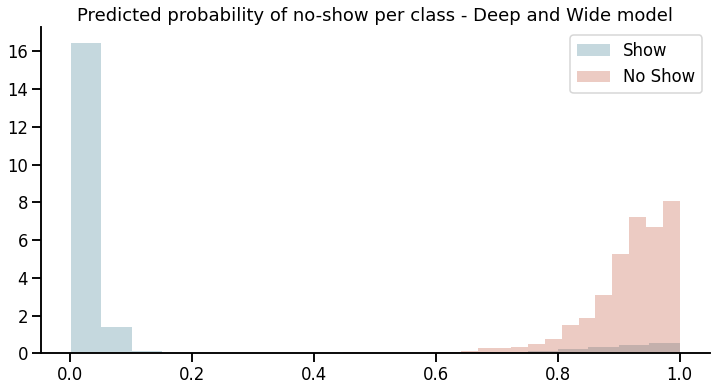

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the distribution of raw probabilities
predictions_nn = model.predict(test_X)
predictions_nn_df = pd.DataFrame({"prediction":predictions_nn.squeeze(),"ground_truth":test_y.squeeze()})

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(x="prediction", data = predictions_nn_df.loc[predictions_nn_df.ground_truth == 0], 
        bins=20, density=True, label='Show',alpha=0.3)
ax.hist(x="prediction", data = predictions_nn_df.loc[predictions_nn_df.ground_truth == 1], 
        bins=20, density=True, label='No Show', alpha=0.3)
ax.set_title("Predicted probability of no-show per class - Deep and Wide model")
sns.despine()
ax.legend()
plt.show()

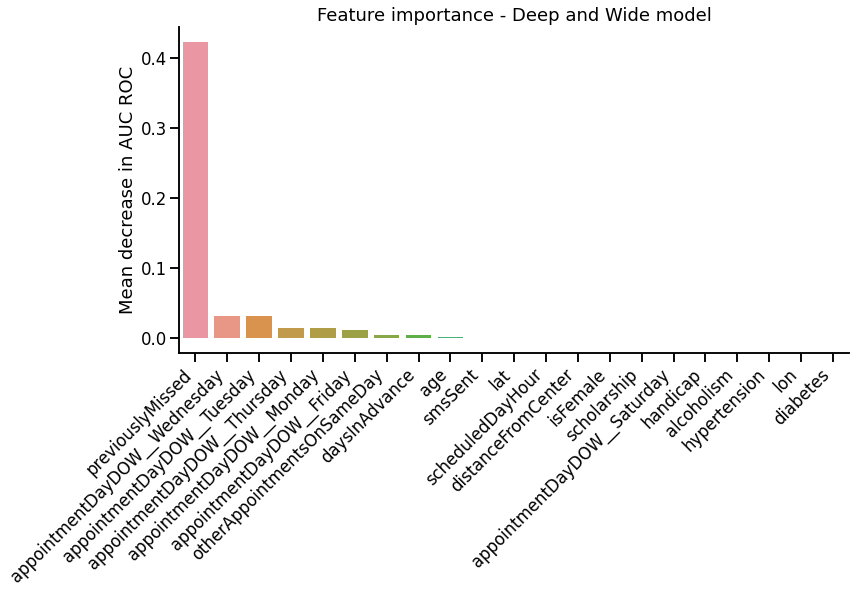

In [18]:
# sensitivity analysis
def score_nn(X, y):
    y_pred = model.predict(X)
    return sklearn.metrics.roc_auc_score(y, y_pred)

# calculate feature importance and the decrease over the ROC AUC score for each variable
base_score, score_decreases = get_score_importances(score_nn, test_X, test_y)
feature_importances = np.mean(score_decreases, axis=0)
feature_importance_df = pd.DataFrame({"feature":no_show_df[FEATURE_COLS].columns.tolist(),
                                      "importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(["importance"],ascending=False)

# plot the feature importance
with sns.color_palette(sns.diverging_palette(220, 20, n=20)):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x="feature",y="importance",data=feature_importance_df)
    ax.set_title("Feature importance - Deep and Wide model")
    ax.set_xticklabels(labels = feature_importance_df.feature, rotation=45,
                       horizontalalignment='right')
    ax.set_xlabel("")
    ax.set_ylabel("Mean decrease in AUC ROC")
    sns.despine()
    plt.show()

#### Comment

The Deep and Wide model shows good performances with an AUC_ROC score which remains stable when performing predictions on previously unseen data.

Overall, the model seems to have found a generalized solution to the problem. Even if a decrease in precision is evident, this can be explained considering that the test set has not been oversampled to mimic as much as possible real operating conditions (the training set therefore contains much more no-shows compared to the test set). 

Moving to the "business" metrics, the recall is in both training and test set above 98%, which is a great result. This means that the model is able to identify most of the patients who are not going to show up to medical appointments. 
The test precision is slightly over 72%, which means our hypothetic no-show team will still have to deal with some false positives. However, the number of unnecessary interventions following the model is getting closer to 3 out of 10, which is a significant improvement over the 8 out of 10 (20% precision score) of the baseline model. 

## XGBoost

In addition to the model built above, I trained an xgboost model to have a comparison with a different type of machine learning model that could potentially solve the problem. XGBoost is the go-to algorithm for most machine learning challenges and it implements gradient boosted decision trees. 

In order to have a fair comparison with the Deep and Wide network, a hyperparameter tuning job has been performed with the same objective of maximizing validation AUC ROC. The implementation can be found in the file 'models/xgboost_hparams_tuning.py' and it's not reported here for brevity. 

In [19]:
# load the best hyperparameters configuration found during the tuning
with open("models/xgboost_params.json","r") as f:
    best_config_xgboost = json.load(f)
print("Best configuration for the XGBoost model:")
print(best_config_xgboost)


Best configuration for the XGBoost model:
{'verbosity': 0, 'num_threads': 2, 'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': ['auc', 'ams@0', 'logloss'], 'colsample_bytree': 0.579080875332521, 'eta': 0.22022077758032105, 'gamma': 0.013397972171065312, 'grow_policy': 'depthwise', 'max_depth': 8, 'min_child_weight': 4}


In [20]:
# prepare the data and train xgboost
train_set = xgb.DMatrix(train_X, label=train_y)
val_set = xgb.DMatrix(val_X, label=val_y)
test_set = xgb.DMatrix(test_X, label=test_y)

bst = xgb.train(best_config_xgboost, train_set, evals=[(val_set, "eval")])

[0]	eval-auc:0.97461	eval-ams@0:79.05188	eval-logloss:0.52822
[1]	eval-auc:0.97445	eval-ams@0:78.60534	eval-logloss:0.42758
[2]	eval-auc:0.97508	eval-ams@0:79.30781	eval-logloss:0.35619
[3]	eval-auc:0.97492	eval-ams@0:79.32027	eval-logloss:0.30748
[4]	eval-auc:0.97548	eval-ams@0:79.88841	eval-logloss:0.27085
[5]	eval-auc:0.97572	eval-ams@0:79.83793	eval-logloss:0.24363
[6]	eval-auc:0.97568	eval-ams@0:79.91623	eval-logloss:0.22578
[7]	eval-auc:0.97568	eval-ams@0:79.83914	eval-logloss:0.21322
[8]	eval-auc:0.97615	eval-ams@0:80.11108	eval-logloss:0.20057
[9]	eval-auc:0.97605	eval-ams@0:80.43633	eval-logloss:0.19265


In [21]:
def evaluate_model(bst,set,ground_truth):
    """Compute the metrics for an xgboost model"""
    preds = bst.predict(set)
    pred_labels = np.rint(preds)
    metrics = {"precision": sklearn.metrics.precision_score(ground_truth,pred_labels),
               "recall": sklearn.metrics.recall_score(ground_truth,pred_labels),
               "AUC_ROC": sklearn.metrics.roc_auc_score(ground_truth,pred_labels)}
    return metrics
    

In [22]:
print("Training set performance:")
for metric, value in evaluate_model(bst,train_set,train_y).items():
    print(metric,"-",value)
print("\nValidation set performance:")
for metric, value in evaluate_model(bst,val_set,val_y).items():
    print(metric,"-",value)

print("\nTest set performance:")
for metric, value in evaluate_model(bst,test_set,test_y).items():
    print(metric,"-",value)

Training set performance:
precision - 0.92075552084073
recall - 0.9992807418633923
AUC_ROC - 0.9566390094787947

Validation set performance:
precision - 0.736805874254245
recall - 0.9972049689440994
AUC_ROC - 0.9541002729410495

Test set performance:
precision - 0.7255911964411145
recall - 0.9951830443159922
AUC_ROC - 0.9524903138150422


In [23]:
# log the run with mlflow
with mlflow.start_run():
    # log the run parameters
    mlflow.log_param("data_path",CSV_PATH)
    mlflow.log_param("algorithm","XGBoost")
    mlflow.log_param("sequential_split", SEQUENTIAL_SPLIT)
    mlflow.log_param("use_SMOTE",USE_SMOTE)
    mlflow.log_param("training_features",FEATURE_COLS)
    mlflow.log_param("hparams_config",best_config_xgboost)
        
    # log the run metrics
    train_metrics = evaluate_model(bst,train_set,train_y)
    test_metrics = evaluate_model(bst,test_set,test_y)
    
    mlflow.log_metric("train_auc",train_metrics["AUC_ROC"])
    mlflow.log_metric("test_auc",test_metrics["AUC_ROC"])
    mlflow.log_metric("train_precision",train_metrics["precision"])
    mlflow.log_metric("test_precision",test_metrics["precision"])
    mlflow.log_metric("train_recall",train_metrics["recall"])
    mlflow.log_metric("test_recall",test_metrics["recall"])

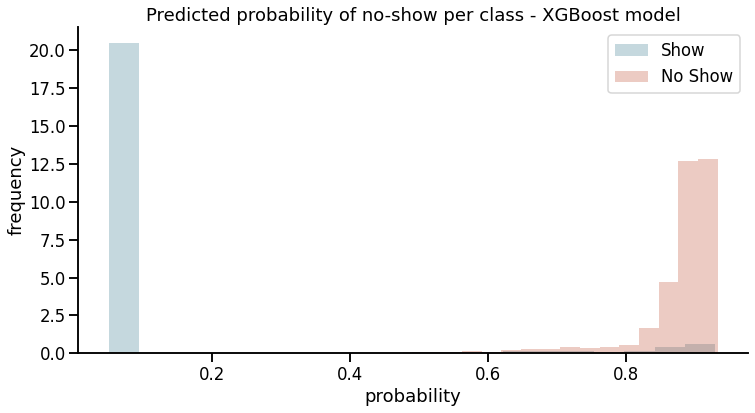

In [24]:
# plot the prediction distribution
predictions_xgb = bst.predict(test_set)
predictions_xgb_df = pd.DataFrame({"prediction":predictions_xgb.squeeze(),"ground_truth":test_y.squeeze()})

fig, ax = plt.subplots(figsize=(12, 6))
#sns.kdeplot(predictions_xgb_df.loc[predictions_xgb_df.ground_truth == 1].prediction, shade=1, color='red', label = "No Show")
#sns.kdeplot(predictions_xgb_df.loc[predictions_xgb_df.ground_truth == 0].prediction, shade=1, color='darkturquoise', label = "Show")
ax.hist(x="prediction", data = predictions_xgb_df.loc[predictions_xgb_df.ground_truth == 0], 
        bins=20, density=True, label='Show',alpha=0.3)
ax.hist(x="prediction", data = predictions_xgb_df.loc[predictions_xgb_df.ground_truth == 1], 
        bins=20, density=True, label='No Show', alpha=0.3)
ax.set_title("Predicted probability of no-show per class - XGBoost model")
ax.set_ylabel("frequency")
ax.set_xlabel("probability")

sns.despine()
ax.legend()
plt.show()

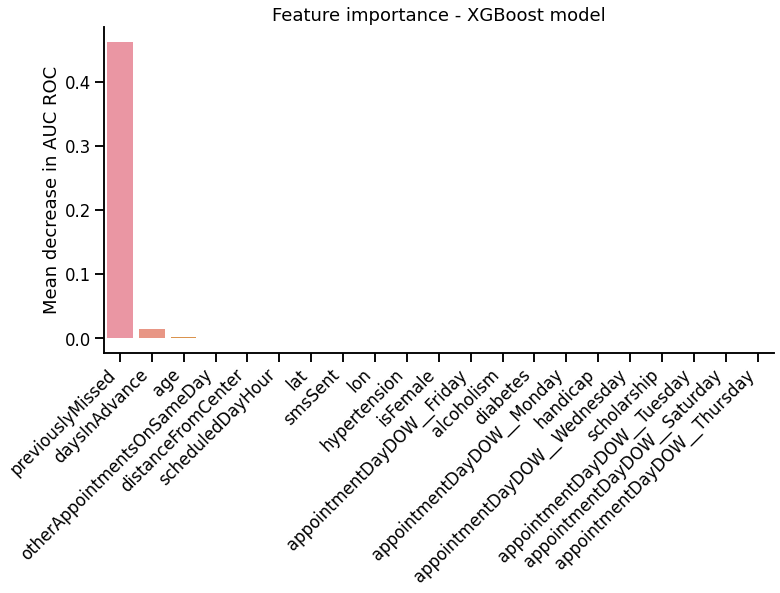

In [25]:
# sensitivity analysis
def score_xgb(X, y):
    val_set = xgb.DMatrix(X, label=y)
    y_pred = bst.predict(val_set)
    return sklearn.metrics.roc_auc_score(y, y_pred)

# compute the score decreases for each variable
base_score, score_decreases = get_score_importances(score_xgb, test_X, test_y)
feature_importances = np.mean(score_decreases, axis=0)
feature_importance_df = pd.DataFrame({"feature":no_show_df[FEATURE_COLS].columns.tolist(),
                                      "importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(["importance"],ascending=False)

#
with sns.color_palette(sns.diverging_palette(220, 20, n=20)):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x="feature",y="importance",data=feature_importance_df)
    ax.set_title("Feature importance - XGBoost model")
    ax.set_xticklabels(labels = feature_importance_df.feature, rotation=45,
                       horizontalalignment='right')
    ax.set_xlabel("")
    ax.set_ylabel("Mean decrease in AUC ROC")
    sns.despine()
    plt.show()

In [26]:
xgb_pred_labels = np.rint(predictions_xgb)
print(sklearn.metrics.classification_report(test_y,xgb_pred_labels))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     12993
           1       0.73      1.00      0.84      3114

    accuracy                           0.93     16107
   macro avg       0.86      0.95      0.90     16107
weighted avg       0.95      0.93      0.93     16107



#### Comment
Also this XGBoost implementation gives some really good results. The precision and recall values are comparable (but higher) with the Deep and Wide network, therefore the same considerations apply. The AUC ROC is higher for the Deep and Wide network, although having loaded the model checkpoints for a different epoch could have changed the outcome of this comparison for all three metrics considered.

## Discussion

A machine learning approach brings clear advantages in reducing the number of no-shows to medical appointments. The recall score close to 100% of the two models explored in this notebook is comparable to the only advantage of the baseline model: don't miss any potential no-show. 

At the same time, a machine learning powered approach can cut through the clutter, reducing the number of cases that are currently wrongly considered potential no-show by over 60%. The dataset covers slightly more than a month and contains over 110k appointments. The possibility of reducing the number of appointments to analyze and act upon could make the problem more manageable and more rewarding for the people involved. 

There is an opportunity to build an interface supporting some machine learning interpretability algorithm (e.g. SHAP values) as a possibility for people working on reducing no-shows to interpret the model and prioritize cases.

Finally, the activation function of the deep and wide network spreads them across the range 0-1, as opposed to the XGBoost classifier which squeezes them at the extreme of the range. This can allow users to prioritize the cases to analyze. 

### Limitations and next steps
* The dataset only convered a period of slightly over than a month. It would be interesting to repeat the analysis with a longer timeframe
    * In this case, the sequential train/validation/test split should be tested again
* Most of the features are orthogonal to the target variable: what other features could be better predictors of medical appointment no-shows?
* Certain variables present issues or unclarified points, for example:
    * No SMS were sent for the equivalent of roughly for one third of the available timeframe. It is not clear what might have happened there. Not enough data is available in the dataset to disregard that portion of data.
    * There is no indication of the time of the day when an appointment should happen. This might be an interesting feature to observe
